In [21]:
from bertopic import BERTopic
import pandas as pd
import os
import matplotlib.pyplot as plt
from bertopic.representation import KeyBERTInspired
import openai

In [22]:
# Function to read API key from a file
def read_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.read().strip()

In [23]:
# Corpus and dictionary files to use
corpus_file = '../../data/democracy_all_predictions_130724.csv'
label_column = 'predicted_dim_roberta'
label = 'ambiguous'
# Read the API key
#api_key_path = '../../openai_api.key'
#openai.api_key = read_api_key(api_key_path)


In [24]:
# Download datsets if not already downloaded
if not os.path.exists(corpus_file):
    print(f'Corpus file not found {corpus_file}')

In [25]:
# load data setof all countries, years and sources
all_countries_data = pd.read_csv(corpus_file)
all_countries_data['sentence'] = all_countries_data['sentence'].astype(str)
df = pd.DataFrame(all_countries_data)
print(df.columns)


/var/folders/pj/wj7m849s68qcg6_lr0j03jgh0000gn/T/ipykernel_7388/2656121593.py:2: DtypeWarning:

Columns (4,5,6,8,9,10,12,13,14,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.



Index(['sentence', 'country', 'year', 'source', 'dimension1_r1',
       'dimension2_r1', 'backsliding_r1', 'start_idea_r1', 'dimension0_r2',
       'dimension1_r2', 'dimension2_r2', 'backsliding_r2', 'dimension0_r3',
       'dimension1_r3', 'dimension2_r3', 'backsliding_r3', 'start_idea_r2',
       'start_idea_r3', 'dimension0_r1', 'correct_dimension',
       'expalained_ambiquous', 'dimension0', 'correct_backsliding',
       'predicted_dim_roberta', 'predicted_dim_roberta_no_ambiguous',
       'predicted_backsliding_123'],
      dtype='object')


In [26]:
amb_df = df[df[label_column] == label]
amb_df = amb_df.reset_index(drop=True)

In [29]:
def get_embedding(text, model="text-embedding-ada-002"):
    response = openai.embeddings.create(input=text, model=model)
    embedding = response['data'][0]['embedding']
    return embedding

#representation_model = None
#docs = amb_df.sentence
#embeddings = [get_embedding(doc) for doc in docs]

In [34]:
# Prepare embeddings
from sentence_transformers import SentenceTransformer
docs = amb_df.sentence
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# Use KeyBERTInspired representation model. 
# This gives better names to the topics.
representation_model = KeyBERTInspired()
embeddings = sentence_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/4164 [00:00<?, ?it/s]

In [60]:
# Dynamic min_topic_size based on the size of the docs
def calculate_min_topic_size(docs, min_percentage=0.001, min_threshold=10):
    calculated_size = max(int(len(docs) * min_percentage), min_threshold)
    return calculated_size



In [61]:
# load BERT model paraphrase-MiniLM-L3-v2 (multilingual) or all-MiniLM-L6-v2 (english)
# ADJUST minimum topic size and max ngrams
MIN_TOPIC_SIZE = calculate_min_topic_size(docs)
print(MIN_TOPIC_SIZE)
MAX_NGRAM = 2

133


In [54]:
#topic_model = BERTopic(representation_model=representation_model,  
#                       verbose=True, 
#                       embedding_model='all-MiniLM-L6-v2', 
#                       min_topic_size = MIN_TOPIC_SIZE, 
#                       n_gram_range=(1, MAX_NGRAM)
#                      ).fit(docs, embeddings)

# Define your BERTopic model with the dynamic min_topic_size
topic_model = BERTopic(representation_model=representation_model,  
                       verbose=True, 
                       embedding_model='all-MiniLM-L6-v2', 
                       min_topic_size = MIN_TOPIC_SIZE, 
                       n_gram_range=(1, MAX_NGRAM))

# Fit the BERTopic model with documents and their corresponding embeddings
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-07-22 14:30:56,058 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-22 14:34:50,461 - BERTopic - Dimensionality - Completed ✓
2024-07-22 14:34:50,463 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

In [56]:

# Reduce the number of topics to 10
topic_model.reduce_topics(docs, nr_topics=10)

# Get the reduced topics
reduced_topics = topic_model.get_topics()

2024-07-22 14:47:52,168 - BERTopic - Topic reduction - Reducing number of topics
2024-07-22 14:47:52,169 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3


In [57]:
# Display reduced topics
for topic, words in reduced_topics.items():
    print(f"Topic {topic}: {words}")

Topic -1: [('implemented greco', 0.57957494), ('greco concludes', 0.56690025), ('greco takes', 0.47346807), ('greco', 0.47130787), ('by greco', 0.42746186), ('recommendation has', 0.42637283), ('satisfactorily greco', 0.40658402), ('partly implemented', 0.3895072), ('greco secretariat', 0.38511324), ('recommendation', 0.37609822)]
Topic 0: [('compliance report', 0.6085129), ('compliance', 0.5294683), ('implemented', 0.3651799), ('greco', 0.33843404), ('evaluation', 0.27868658), ('the authorities', 0.2589916), ('report', 0.25701064), ('authorities', 0.24443915), ('recommendation', 0.23413919), ('recommendations', 0.21516052)]
Topic 1: [('financement des', 0.51436627), ('campagnes électorales', 0.50984544), ('partis politiques', 0.4995935), ('le financement', 0.47220656), ('électorale', 0.46739084), ('électorales', 0.46582013), ('commission électorale', 0.46259326), ('financement', 0.43313426), ('du financement', 0.4218468), ('élections', 0.39709678)]


In [59]:
topic_model.visualize_documents(docs, embeddings=embeddings)

KeyboardInterrupt: 

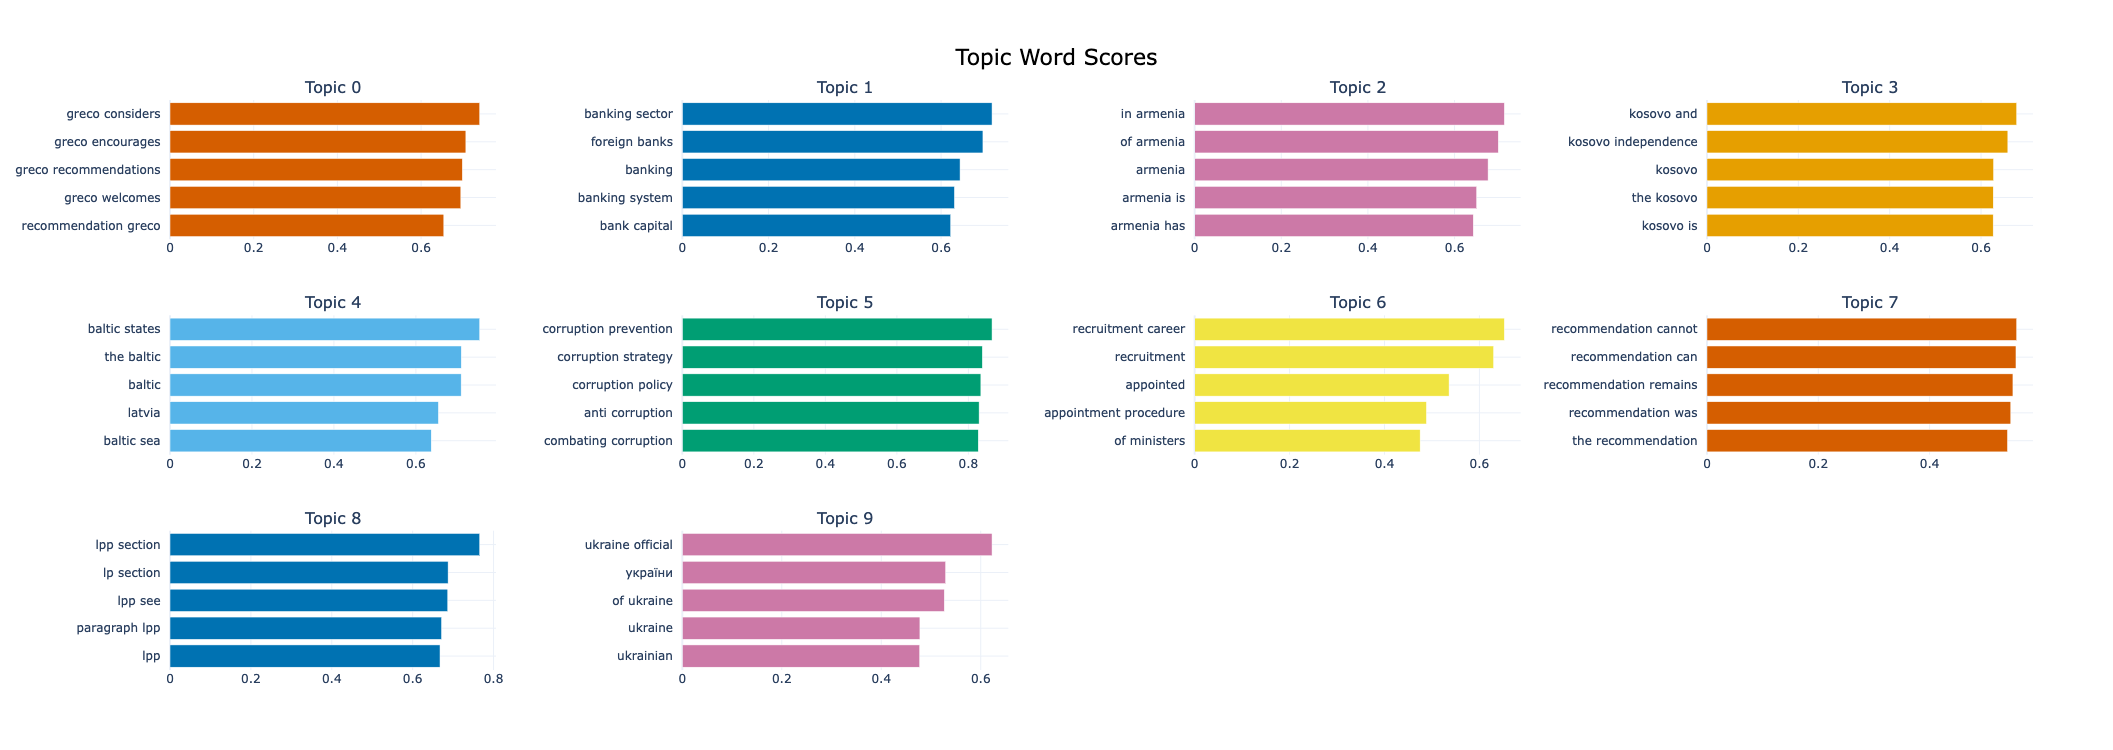

In [47]:
# visualize topic words/n_grams
fig = topic_model.visualize_barchart(top_n_topics=10)
fig.show()

In [40]:
topic_model.visualize_topics()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# visualize topic clusters
topic_model.visualize_hierarchy(top_n_topics=30)